# Classes for the O2 solver: voxelized method

### Grid class

In [79]:
import matplotlib.pyplot as plt
# import numba

import scipy.sparse as sp
import numpy as np

import cupyx.scipy.sparse as csp
import cupyx.scipy.sparse.linalg as cspl
import cupy as cp

from typing import Union, Tuple, List
from itertools import groupby
import graph_tool as gt
from graph_tool.generation import lattice
from graph_tool.draw import graph_draw
from graph_tool.util import find_edge
from tqdm import tqdm
import cProfile as profile
from numpy import ma
import itertools
import time

import cProfile as profile
from matplotlib.collections import LineCollection

withAstropy = False

### Some utils

In [80]:
def get_prop_type(value, key=None):
    """
    Performs typing and value conversion for the graph_tool PropertyMap class.
    If a key is provided, it also ensures the key is in a format that can be
    used with the PropertyMap. Returns a tuple, (type name, value, key)
    """
    
    if key=='position':
        tname = 'vector<float>' # Somehow using vectors doesn't allow for substraction
    elif key == 'plexus':
        tname = 'short'
        value = int(value)
    elif key == 'stage':
        tname = 'short'
        try: 
            value = int(value)
        except ValueError:
            value = 10
    elif key=='nodeType':
        tname = 'string'
        value = str(value)
    elif key in ['radius','pressure','length','hd','flow']:
        tname = 'float'
        try:
            value = float(value)
        except ValueError:
            value = 0.0

    else:    

        if isinstance(key, str):
            # Encode the key as ASCII
            tname = 'string'
            key = key.encode('ascii', errors='replace')

        # Deal with the value
        if isinstance(value, bool):
            tname = 'bool'

        elif isinstance(value, int):
            tname = 'float'
            value = float(value)

        elif isinstance(value, float):
            tname = 'float'

        elif isinstance(value, str):
            tname = 'string'
            value = str(value.encode('ascii', errors='replace'))

        elif isinstance(value, dict):
            tname = 'object'

        else:
            tname = 'string'
            value = str(value)

    return str(tname), value, key

# @numba.njit
def DecompressRLE(RLElabels:np.ndarray, arrayShape) -> np.ndarray:
    '''
    Decompress the grid labels into a full array of int.
    '''
    res = np.empty(arrayShape[0]*arrayShape[1]*arrayShape[2], np.uint8)
    ii = 0
    for i in range(0, RLElabels.size, 2):
        value = RLElabels[i]
        rep   = RLElabels[i+1]
        for j in range(0,rep):
            res[ii] = value
            ii += 1
    res = res.reshape(arrayShape)
    return res
    
def CompressRLE(labels:np.ndarray) -> np.ndarray:
    '''Compress the grid labels to RLE.'''
    return np.asarray([[val, sum(1 for i in group)] for val,group in groupby(labels.flat)]).flatten()

In [81]:
class Grid(object):
    def __init__(self, origin:tuple[float], sideLengths:tuple[float], shape:tuple[int])->None:
        """
        Initialize a 3D grid with the specified shape.

        Parameters:
        - origin (tuple): The location of the bottom, left, front corner (i.e., index 0 o the grid), e.g., (0,0,0)
        - sideLengths (tuple): The length of each side of the grid (e.g., (1.0,1.2,1.5))
        - shape (tuple): The shape of the grid (e.g., (3, 3, 3)).
        """
        self.n = np.asarray(shape)
        self.origin = np.asarray(origin)
        self.l = np.asarray(sideLengths)
        self.h = np.asarray([l/(n-1) for l,n in zip(self.l, self.n)])
        self.labels = {}

    def __getitem__(self, idx)->float:
        return self.grid[idx]
    def __iter__(self):
        for i in range(self.size):
            try:
                yield self.labels[i]
            except KeyError:
                yield 0

    @property
    def shape(self)->tuple[int]:
        return self.n
    @property
    def size(self)->int:
        return np.prod(self.shape)

    def GetItem(self, flatIndex:int)->float:
        '''Returns grid entry based on a flat index.'''
        return self.flatGrid[flatIndex]    

    def GetNeighbors(self, i,j,k)->np.ndarray:
        """Get the direct neighbors of a cell at the specified indices."""
        neighbors = []
        for di in range(-1, 2):
            for dj in range(-1, 2):
                for dk in range(-1, 2):
                    if not 0<sum(abs(d) for d in (di,dj,dk))<=1:
                        continue # Skip diagonal neighbours and call to cell itself
                    ni, nj, nk = i + di, j + dj, k + dk
                    if 0 <= ni < self.shape[0] and 0 <= nj < self.shape[1] and 0 <= nk < self.shape[2]:
                        neighbors.append(self.grid[ni,nj,nk])
        return np.asarray(neighbors)
    
    def ToFlatIndex(self, i:int,j:int,k:int)->int:
        '''Returns the index in the flattened array.'''
        #return self.shape[1] * (i*self.shape[0] + j) + k
        return np.ravel_multi_index((i,j,k), dims=self.shape, mode='wrap')
    def To3DIndex(self, idx:int)->tuple[int]:
        '''Returns the 3D index.'''
        # i = idx // (self.shape[0]*self.shape[1])
        # j = (idx - i*self.shape[0]*self.shape[1]) // self.shape[0]
        # k = idx - self.shape[1] * (j + self.shape[0]*i)
        # return (i,j,k)
        return np.unravel_index(idx, shape=self.shape)


    def ProbeAlongLine(self, start:tuple[float], end:tuple[float]):
        '''
        TODO, see https://code.activestate.com/recipes/578112-bresenhams-line-algorithm-in-n-dimensions/
        '''
        print("Not implemented yet.")
        return
    
    def Dist(self,
             cell1 : Union[List[int], Tuple[int], np.ndarray],
             cell2 : Union[List[int], Tuple[int], np.ndarray]) -> int:
        return int(np.sum(np.abs(np.array(cell1)-np.array(cell2))))

    def _BoundingBoxOfVessel(self, p1 : np.ndarray, p2 : np.ndarray,
                             r : float) -> Tuple[np.ndarray, np.ndarray]:
        '''
        Finds the bounding box for the vessel with end points p1 and p2
        in cell coordinates (i,j,k indices).
        For formulas, see https://iquilezles.org/articles/diskbbox/
        '''
        n = (p1-p2) # The axis of the cylinder
        n = r*(1-(n/np.linalg.norm(n))**2)**0.5 # The direction, orthogonal to the axis,
                                                # where to pick the bounding box corners
        # Find bounding box for the cylinder as the bounding box of the
        # bounding boxes of its caps (the disk faces)
        bboxes = np.array([p1 - n, p1 + n, p2 - n, p2 + n])
        cellMin, cellMax = self.PointToCell(bboxes.min(axis=0)), self.PointToCell(bboxes.max(axis=0))
        return np.maximum(cellMin, [0,0,0]), np.minimum(cellMax, self.n-1)
    
    def PointToCell(self, X: Union[List[float], Tuple[float], np.ndarray]) -> np.ndarray:
        # Center and normalize
        X = np.divide(np.asarray(X).reshape((3,-1)) - self.origin[:,np.newaxis], self.l[:,np.newaxis]) 
        xVoxelSpace = np.multiply(X, self.n[:,np.newaxis]) # Project onto voxel space
        return np.floor(xVoxelSpace).astype(int)
    
    def CellCenter(self, ijk : Union[np.ndarray, List[int], int, Tuple[int]]) -> np.ndarray:
        if isinstance(ijk, int):
            ijkarr = np.asarray(self.To3DIndex(ijk))
        ijkarr = np.asarray(ijk).reshape((3,-1)) 
        if ((ijkarr-self.n[:,np.newaxis]) > 0).any():
            raise ValueError(f"Indices {ijkarr[((ijkarr-self.n[:,np.newaxis])>0).any(1)]} out of bounds for the grid.")        
        cellCenter = self.origin[:,np.newaxis] + self.l[:,np.newaxis] * ((0.5+ijkarr)/self.n[:,np.newaxis])
        return np.squeeze(cellCenter)
    
class VascularGraph(gt.Graph):
    
    def __init__(self, graphFile:str=None) -> None:
        # super(VascularGraph, self).__init__(directed=True)
        if graphFile:
            G = self._ReadFromFile(graphFile)
            sort = gt.topology.topological_sort(G)
            G.vp['sort'] = G.new_vertex_property('int', vals=sort)
            super(VascularGraph, self).__init__(G, directed=True, vorder=G.vp['sort'])
            self.graphFile = graphFile
            self.vp['sort'] = self.new_vertex_property('int')
            self.vp['sort'].a = sort
            print(self.vp['sort'])
        else:
            super(VascularGraph, self).__init__(directed=True)
    
    def _ReadFromFile(self, graphFile:str):
        def ifFloat(x):
            try:
                return float(x)
            except ValueError:
                return x
        
        G = gt.Graph()
        with open(graphFile, 'r') as f:
            line = f.readline()
            while not line.startswith('# Nodes'):
                line = f.readline()
            nNodes = int(line.split(' ')[-1])
            attributes = f.readline().strip('\n').split(',')[1:] # First item is node name
            nodes = []
            for n in range(nNodes):
                node = f.readline().strip('\n').split(',')
                nodes.append((node[0], [ifFloat(node[i+1]) if attributes[i]!='position'
                                        else np.array(list(map(float, node[i+1].strip('[').strip(']').split()))) 
                                        for i in range(len(attributes))]))
            nodeAttributes = [n for n in attributes] # Copy
            line = f.readline()
            while not line.startswith('# Edges'):
                line = f.readline()
            nEdges = int(line.split(' ')[-1])
            attributes = f.readline().strip('\n').split(',')[2:] # First two items are node names
            edges = []
            for n in range(nEdges):
                edge = f.readline().split(',')
                edges.append((edge[0], edge[1], [ifFloat(edge[i+2]) for i in range(len(attributes))]))
            edgeAttributes = [n for n in attributes] # Copy
            
        # Convert to integers before adding to graph
        nodesToInt = {n[0]:i for i,n in enumerate(nodes)}
        nodes = [[nodesToInt[n], [get_prop_type(value, key)[1] for key, value in zip(nodeAttributes, d)]] for n,d in nodes]    
        edges = [(nodesToInt[n1], nodesToInt[n2], *[get_prop_type(value, key)[1] for key, value in zip(edgeAttributes, d)]) for n1,n2,d in edges]
        G.add_edge_list(edges,
                    eprops=[get_prop_type(value, key)[::-2] for key, value in zip(edgeAttributes, edges[0][2:])],        
                    )
        del edges, nodesToInt
        
        vprops = [G.new_vertex_property(get_prop_type(value,key)[0]) for key, value in zip(nodeAttributes, nodes[0][1])]
        for i, vprop in enumerate(vprops):
            G.vp[nodeAttributes[i]] = vprop
            if vprop.value_type() not in ['python::object','string', 'vector<double>', 'vector<long double>']:
                vprop.a = [d[i] for _,d in nodes]
            elif vprop.value_type() in ['string', 'python::object']:
                for n,d in nodes:
                    vprop[n] = d[i]
            else:
                vprop.set_2d_array(np.array([d[i] for _,d in nodes]).T, pos=np.array([n for n,_ in nodes]))
        del nodes
        return G
    
    def SplitVesselsToMeshSize(self, h:float, vessels:list):
        print("Not implemented yet.")
        pass

class ControlVolumes(object):
    '''
    Creates the control volumes within the Grid and stores the connections and their types
    between the grid and the control volumes (endothelial and (optional) vascular voxels)
    and between the vascular nodes and the control volumes.
    '''
    def __init__(self, grid:Grid, vessels:VascularGraph):
        # Compute distance to grid.origin along each axis
        d = vessels.new_vertex_property("bool")

        graph = vessels.copy()
        vorder = graph.new_vertex_property("int")
        vorder.a = np.arange(graph.num_vertices())[gt.topology.topological_sort(graph)]
        self._vessels = gt.Graph(graph, directed=True, vorder=vorder)
        # pos = self._vessels.vp['position']
        # #inFOV = (np.abs(np.array([pos[u] for u in vessels.iter_vertices()])-grid.origin)<=grid.l)
        # positions = vessels.vp['position'].get_2d_array([0,1,2]) - grid.origin.reshape((3,1))        
        points = self._vessels.vp['position'].get_2d_array([0,1,2]) 
        d.a = np.logical_and((points<=grid.origin[:,np.newaxis]+grid.l[:,np.newaxis]), (points>=grid.origin[:,np.newaxis])).all(0)
        self.grid = grid
        self.VAG = gt.GraphView(self._vessels, vfilt=d)


    def _RotationMatrix(self, n:np.ndarray):
        """Rotate a capsule onto the vessel axis n."""
        if (n==[0,0,1]).all():
            return np.eye(3)
        if (n==[0,0,-1]).all():
            R = np.array([[0,0,0],[0,0,0],[0,0,-1]])                                
        R = (n[2]-1)/(n[0]**2+n[1]**2) * np.array([[n[0]**2, n[0]*n[1], 0],
                                                    [n[0]*n[1], n[1]**2, 0],
                                                    [0, 0, n[0]**2+n[1]**2]])                      
        R+= np.array([[1, 0, -n[0]],
                        [0, 1, -n[1]],
                        [n[0], n[1], 1]])                              
        return R
    
    def _LabelRefCapsule(self, r:float, l:float, w:float,):
                        # nx:int=50, ny:int=50, nz:int=100):
        """
        Samples point around the refrence capsule 
        (a vertical cylinder of length l and radius r)
        and labels them according to the lumen radius and vessel wall thickness (w).
        """    
        # Creates a 3D grid, large enough for the capsule to fit in
        # pos    = np.meshgrid(np.linspace(-1.1*(r-w), 1.1*(r+w), endpoint=True, num=nx),
        #                     np.linspace(-1.1*(r-w), 1.1*(r+w), endpoint=True, num=ny),
        #                     np.linspace(0, l, endpoint=True, num=nz)) 
        width = r+w # Width of the cylinder
        pos = np.meshgrid(np.arange(-width, width, w),
                            np.arange(-width, width, w),
                            np.arange(-r, l+r, min(l, min(self.grid.h))))
        pos = np.vstack(list(map(lambda x:x.ravel(), pos))) # (3,nx*ny*nz) array of locations
        dists = np.linalg.norm(pos[:2], axis=0) # Distance from the cylinder axis
        labels = np.where(dists<r-w/2, 1, np.where(dists<r+w/2, 2, 0))
        # labels = np.where(dists<r+w, 2, 0)
        # labels[dists<r-w] = 1
        return pos, labels
    
    def _LabelAroundVessel(self, e:list, w:float):
        ''' 
        TODO: look for the closest node in the edge to assign the connectivity to. Should then return 4 sets (2 for each node). 
        ### Parameters:
        - e: list
            An edge.
        - w: float
            The endothelium thickness (in cm).
        '''

        p0, p1 = [self.VAG.vp['position'][n].a for n in e]
        r, l   = self.VAG.ep['radius'][e], self.VAG.ep['length'][e] 
        R = self._RotationMatrix((p1-p0)/l) # Rotation operator to the vessel axis

        pos, labels = self._LabelRefCapsule(r, l, w) # Return a grid with its labels on a vertical capsule
        m0 = pos[-1,:]<l/2 # The cells that should be attached to the proximal node's control volume
        pos = p0[:, np.newaxis] + R.T.dot(pos) # Transpose and translate the capsule to the real vessel's axis
        gridDomain = self.grid.PointToCell(pos) # Maps the points in the reference capsule to voxels in our grid
        
        mask = (gridDomain<self.grid.n[:,np.newaxis]).all(0) # Some points may be outside the grid after rotation, so we mask them
        mask = mask & (gridDomain>0).all(0)
        labels = labels[mask]
        m0 = m0[mask]
        ijk = self.grid.ToFlatIndex(*gridDomain)[mask] # Maps the ijk indices to flat array indices        
        # try:
        endothelium0 = ijk[ma.masked_where(m0, labels, 0)==2]
        endothelium1 = ijk[ma.masked_where(~m0, labels, 0)==2]
        vascular0    = ijk[ma.masked_where(m0, labels, 0)==1]
        vascular1    = ijk[ma.masked_where(~m0, labels, 0)==1]
        # except IndexError:
        #     print(ijk.shape, labels.shape, labels[np.logical_and(mask, m0)].shape, labels[np.logical_and(mask, ~m0)].shape)
        #     raise IndexError("")
        vascular0 = set(vascular0) # The vascular labels
        endothelium0 = set(endothelium0) # The endothelium labels
        vascular1 = set(vascular1) # The vascular labels
        endothelium1 = set(endothelium1) # The endothelium labels
        vascular0 = vascular0-endothelium0 # Endothelium label is preffered over vascular  
        vascular1 = vascular1-endothelium1 # Endothelium label is preffered over vascular  
        del pos, ijk, labels, gridDomain # Clean up          
        return endothelium0, vascular0, endothelium1, vascular1 
        
    def LabelMesh(self, w:float=1e-4)->None:
        '''
        TODO: see _LabelAroundVessel.
        Labels the mesh and saves the connectivity between the control volumes, the mesh and the vascular nodes. 
        ### Parameters
        - w: float
            The endothelium thickness (in cm).
        '''

        LabelVessel = self._LabelAroundVessel
        # endo = self.VAG.new_vertex_property("python::object", val=set())
        # vasc = self.VAG.new_vertex_property("python::object", val=set())

        G = self.VAG.copy()
        G.clear_edges()
        G.shrink_to_fit()
        Voxels = np.fromiter(G.add_vertex(self.grid.size), dtype=int)
        eType = G.new_edge_property("bool") # 0 for vascular, 1 for endothelial connections

        for e in tqdm(self.VAG.iter_edges(), 
                        total=self.VAG.num_edges(), 
                        desc="Labelling...", unit="edge"): # Loop through the vessels in the FOV.
            # This should loop through the edges within the FOV, but the index of the vertices
            # is the same as in the original graph (therefore, the indices do not necesseraly start at 0).
            # endo0, vasc0, endo1, vasc1 = LabelVessel(e, w) # Save the sets of connections to the grid 
                                                            # as vertex properties of the proximal node.
                                                            # Should be connected to the closest node, but that's simpler.
            # endo[e[0]].update(endo0) # Update does not allow duplicates. Check for speed if allowing duplicates now and removing them later is faster.
            # vasc[e[0]].update(vasc0)
            # endo[e[1]].update(endo1)
            # vasc[e[1]].update(vasc1)
            for u, voxelsSet, t in zip((e[0],e[0], e[1], e[1]), LabelVessel(e,w), (1,0,1,0)):
                G.add_edge_list(((u, v, t) for v in voxelsSet), eprops=[eType])
        del voxelsSet

        edgesToKeep = []
        Voxels = Voxels[G.get_total_degrees(Voxels)>0]
        for v in tqdm(Voxels):
            edges = G.get_all_edges(v, eprops=[eType])
            if (edges[:,-1]==1).any():
                edge = edges[edges[:,-1]==1][0]
            else:
                edge = edges[0]
            edgesToKeep.append(edge)
        # Make it an internal property
        self.VAG.vp['endothelium'] = self.VAG.new_vertex_property("python::object", val=[])
        self.VAG.vp['vascular']    = self.VAG.new_vertex_property("python::object", val=[])

        vasc = find_edge(G, eType, 0)
        endo = find_edge(G, eType, 1)
        vertex_index = G.vertex_index
        for cv, voxel in tqdm(vasc, desc="Adding vascular voxels to graph"):
            self.VAG.vp['vascular'][cv].append(vertex_index[voxel])
        for cv, voxel in tqdm(endo, desc="Adding endothelium voxels to graph"):
            self.VAG.vp['endothelium'][cv].append(vertex_index[voxel])

        # self.VAG.vp['endothelium'] = endo
        # self.VAG.vp['vascular']    = vasc


    def bar(self): # To profile the time for labelling.
        profile.runctx('self.LabelMesh()', globals(), locals())

    def LabelsToGrid(self):
        # Write the labels to the grid for plotting.
        try:
            # self.grid.labels = {i:1 for idx in tqdm(itertools.chain(self.VAG.vp['vascular']), total=self.VAG.num_vertices(), unit='vertices') for i in idx}
            self.grid.labels = {idx:1 for idx in itertools.chain.from_iterable(self.VAG.vp['vascular'])}
            self.grid.labels = {**self.grid.labels, 
                                **{idx:2 for idx in itertools.chain.from_iterable(self.VAG.vp['endothelium'])}}        
        except KeyError:
            self.grid.labels = {} # No labels.
        
    def ToVTK(self, VTKFileName:str="gridLabels.vtk"): 
        self.LabelsToGrid()
        with open(VTKFileName, 'w') as f:
            f.write("# vtk DataFile Version 5.1\n")
            f.write("A mesh for the computation of oxygen perfusion.\n")
            #f.write("BINARY\n")
            f.write("ASCII\n")
            f.write("DATASET STRUCTURED_POINTS\n")
            f.write("DIMENSIONS {:d} {:d} {:d}\n".format(*(self.grid.n+1)))
            f.write("ORIGIN {:f} {:f} {:f}\n".format(*self.grid.origin))
            f.write("SPACING {:f} {:f} {:f}\n".format(*self.grid.h))
        
            # Writing the data
            f.write(f"CELL_DATA {self.grid.size}\n")
            f.write("SCALARS labels int 1\n")
            f.write("LOOKUP_TABLE default\n")

            a = np.array(
                [
                    self.grid.labels.get(i,0) for i in 
                        tqdm(
                            # Change the order to x change the fastest and z the slowest for paraview.
                                np.arange(self.grid.size).reshape(self.grid.shape).ravel('F'), 
                            unit='labels',
                            desc=f"Writing labels to {VTKFileName}",
                            total=self.grid.size)
                ],
                dtype=np.int8
                )
            a.tofile(f, sep='\n', format='%d')
            del a

            # f.write(('\n'.join(i.__str__() for i in 
            #                    tqdm(self.grid, desc=f"Writing labels to {VTKFileName}", 
            #                         total=self.grid.size, unit=' Labels'))))   
        return          

    def _PlotPlexus(self, plexus:int, output=None):
        _G = gt.GraphView(self.VAG, vfilt=self.VAG.vp['plexus'].fa==plexus)
        if _G.num_vertices()==0:
                print(f"No vertices in the " + ("SVP" if plexus==0 else
                                            "ICP" if plexus==1 else
                                            "DCP") + " layer. Not plotting.")
                return
        graph_draw(_G, pos=self.VAG.vp['position'], bg_color='white', output=output)
        del _G
    def PlotSVP(self, output=None):
        self._PlotPlexus(plexus=0, output=output)             
    def PlotICP(self, output=None):
        self._PlotPlexus(plexus=1, output=output)
    def PlotDCP(self, output=None):
        self._PlotPlexus(plexus=2, output=output)           


In [82]:
def LabelACapsule(r:float, l:float, w:float, nx:int=20, ny:int=20, nz:int=20):
    """
    Samples point around the refrence capsule 
    (a vertical cylinder of length l and radius r)
    and labels them according to the lumen radius and vessel wall thickness (w).
    """    
    # pos    = np.meshgrid(np.linspace(-1.5*r, 1.5*r, endpoint=True, num=nx),
    #                      np.linspace(-1.5*r, 1.5*r, endpoint=True, num=ny),
    #                      np.linspace(0, l, endpoint=True, num=nz))
    width = r+1.2*w # Width of the cylinder
    pos = np.meshgrid(np.arange(-width, width, w*2),
                        np.arange(-width, width, w*2),
                        np.arange(0, 1*l, w))
    nx, ny, nz = pos[0].shape
    pos = np.vstack(list(map(lambda x:x.ravel(), pos))) # (3,nx*ny*nz) array of locations
    dists = np.linalg.norm(pos[:2], axis=0) # Distance from the cylinder axis
    labels = np.where(dists<=r-w, 1, np.where(dists<r+w, 2, 0)) # Vascular voxels first, then endothelial
    return pos.reshape((3,nx,ny,nz)), labels.reshape((nx,ny,nz))     

def AddIntermediateVertices(graph:VascularGraph, edge:list[int], num_intermediate:int):
    if num_intermediate<1:
        return
    source, target = edge
    originalEdgeProp = {key: graph.ep[key][edge] for key in graph.ep if key!='length'}
    originalNodeProp = {key: graph.vp[key][source] for key in graph.vp if key!='position'}
    p0, p1 = graph.vp['position'][source].a, graph.vp['position'][target].a
    l = np.linalg.norm(p0-p1)/(num_intermediate+1)
    n = (p1-p0)/np.linalg.norm(p0-p1)
    graph.remove_edge(edge)
    newNodes = graph.add_vertex(num_intermediate)
    for i, newNode in enumerate(newNodes if num_intermediate>1 else [newNodes]):   
        for key, value in originalNodeProp.items():
            graph.vp[key][newNode] = value  
        graph.vp['position'][newNode] = p0 + n*l*(i+1)     
        newEdge = graph.add_edge(source, newNode)
        for key, value in originalEdgeProp.items():
            graph.ep[key][newEdge] = value 
        graph.ep['length'][newEdge] = l
        source = newNode
    newEdge = graph.add_edge(newNode, target)
    for key, value in originalEdgeProp.items():
        graph.ep[key][newEdge] = value 
    graph.ep['length'][newEdge] = l

def SplitVessels_NoReordering(graph:VascularGraph, h:list[float]):
    edges = list(graph.iter_edges())
    positions = graph.vp['position']
    num_intermediates = abs(np.array([[positions[u].a-positions[v].a] for u,v in edges]))/np.asarray(h)
    num_intermediates = np.squeeze(num_intermediates, 1).max(-1).astype(int)    
    for edge, num_intermediate in tqdm(zip(edges, num_intermediates), desc='Refining vascular mesh', total=len(edges), unit='edges'):
        if num_intermediate<1:
            continue
        AddIntermediateVertices(graph, edge, num_intermediate+1)
    return

def SplitVessels(CV:ControlVolumes, h:list[float]):
    graph = CV._vessels.copy()
    vfilter, isInverted = CV.VAG.get_vertex_filter()
    if isInverted:
        vfilter.a = np.invert(vfilter)    
    graph.vp['vfilt'] = graph.new_vertex_property("bool", vfilter.a)

    edges = list(CV.VAG.iter_edges())
    positions = graph.vp['position']
    # Estimate number of splittings necessary to have l<h
    num_intermediates = abs(np.array([[positions[u].a-positions[v].a] for u,v in edges]))/np.asarray(h) 
    num_intermediates = np.squeeze(num_intermediates, 1).max(-1).astype(int)    
    for edge, num_intermediate in tqdm(zip(edges, num_intermediates), desc='Refining vascular mesh', total=len(edges), unit='edges'):
        if num_intermediate<1:
            continue
        AddIntermediateVertices(graph, edge, num_intermediate+1)

    # Reorder the vessels and replace the CV internal graph
    vfilter, isInverted = CV.VAG.get_vertex_filter()
    if isInverted:
        vfilter.a = np.invert(vfilter)
    vorder = graph.new_vertex_property("int")
    for i,v in enumerate(gt.topology.topological_sort(graph)):
        vorder[v] = i
    CV._vessels = gt.Graph(graph, directed=True, vorder=vorder)
    CV._vessels.vp['sort'] = CV._vessels.new_vertex_property("int", vorder.a)
    CV.VAG = gt.GraphView(CV._vessels, vfilt=CV._vessels.vp['vfilt'])    
    del CV._vessels.vp['vfilt'], CV.VAG.vp['vfilt']
    return 

### Test the labelling through reference capsule and rotation

In [83]:
convertMicron = 1e-5

# Vessel parameters
vy = 50 * convertMicron # Length of the vessel, along the y-axis, in micron
r = 5 * convertMicron # Radius of the vessel, in micron
# Grid parameters
nx,ny,nz = 25,50,25      # Number of discretization point in each direction
lx,ly,lz = 50 * convertMicron, 100 * convertMicron, 50 * convertMicron # Cube's sides lengths, in micron
cx,cy,cz = -25 * convertMicron, -25 * convertMicron, -25 * convertMicron # Location of the bottom, left, back corner of the cube, in microns
h = lx/nx # Voxel size length
assert all(l/n==h for l,n in zip((lx,ly,lz), (nx,ny,nz))), "Currently, the discretization assumes the voxels to be cubes (all sides must have the same length)."

# Physiological parameters
convertVolumetricFlow = (1e-6)/60 
q0 = 1e-1 * convertVolumetricFlow # 5 mu^3/min to L/s
Hd = 0.4 # Haematocrit 
C0 = 0.02 # Mol/L (What is that?)
# alpha = 1.2e-6 # Mol/L/mmHg, oxygen plasma solubility
alpha = 2.82e-5 * 1e3 # mlO2/mmHg/L from "Dynamic model of oxygen transport from capillaries to tissue with moving red blood cells." 
alpha_t = 3.89e-5 * 1e3 # mlO2/mmHg/L from "Dynamic model of oxygen transport from capillaries to tissue with moving red blood cells." 
Gamma_v = 1.77e3 * (convertMicron**2) # in mum2/s the permeability of the vessel wall to O2
h_v = 1 * convertMicron # In micons, the vessel wall thickness
Gamma_t = 1.8e3 * (convertMicron**2) # in mum2/s the oxygen diffusivity in tissue
K = 0.4 # 1/s, the oxygen consumption rates

# Boundary conditions
RO2 = 62.36 # Ideal gas constant for O2, L.mmHg/(K.Mol)
Tret = 308.15 # 35*C in Kelvin, the temperature of the retina (roughly)
cIn = 50 * alpha # mmHg to molO2/L = free plasma oxygen concentration
ctBC = 40 * alpha_t # / (RO2 * Tret)  # mmHg to molO2/L 

print(f"Boundary conditions: {cIn=}, {ctBC=}")
print(f"Dynamics parameters: {Gamma_t=}, {Gamma_v=}")
print(f"Vessel parameters: {r=}, {vy=}, {q0=}, {h_v=}")
print(f"Grid parameters: {(lx,ly,lz)=}, {(cx,cy,cz)=}, {h=}")

Boundary conditions: cIn=1.41, ctBC=1.5559999999999998
Dynamics parameters: Gamma_t=1.8000000000000002e-07, Gamma_v=1.7700000000000004e-07
Vessel parameters: r=5e-05, vy=0.0005, q0=1.6666666666666667e-09, h_v=1e-05
Grid parameters: (lx,ly,lz)=(0.0005, 0.001, 0.0005), (cx,cy,cz)=(-0.00025, -0.00025, -0.00025), h=2e-05


In [84]:
print(f"{Gamma_v/(q0*h_v)=}")
print(f"Intravascular inlet O2 concentratioN: {cIn=}")
print(f"Tissue O2 concentration (boundary condition): {ctBC=}")
print(f"{Gamma_t/K=}")
print(f"{22.4*alpha=}, {1/(RO2*Tret)=}")

Gamma_v/(q0*h_v)=10620000.000000002
Intravascular inlet O2 concentratioN: cIn=1.41
Tissue O2 concentration (boundary condition): ctBC=1.5559999999999998
Gamma_t/K=4.5000000000000003e-07
22.4*alpha=0.6316799999999999, 1/(RO2*Tret)=5.203933299313488e-05


In [85]:
if withAstropy:

    import astropy.units as u

    mlO2 = u.def_unit("mlO2", u.ml) 
    molO2 = u.def_unit("molO2", 0.001 * mlO2 * 44.64*u.umol/u.ml)
    mlO2ToMol = 44.64 * u.umol / u.ml

    convertMicron = 1e-5
    L = u.nm
    T = u.s
    M = u.zmol

    print("Length unit:", L.names[-1])
    print("Time unit:", T.names[-1])
    print("Molar unit:", M)

    # Vessel parameters
    vy = 50 * u.micron # Length of the vessel, along the y-axis, in micron
    r = 5 * u.micron   # Radius of the vessel, in micron
    # Grid parameters
    nx,ny,nz = 25,50,25      # Number of discretization point in each direction
    lx,ly,lz = 50 * u.micron,100 * u.micron, 50 * u.micron # Cube's sides lengths, in micron
    cx,cy,cz = -25 * u.micron, -25 * u.micron, -25 * u.micron # Location of the bottom, left, back corner of the cube, in microns
    h = lx/nx # Voxel size length
    assert all(l/n==h for l,n in zip((lx,ly,lz), (nx,ny,nz))), "Currently, the discretization assumes the voxels to be cubes (all sides must have the same length)."

    # Physiological parameters
    convertVolumetricFlow = (1e-6)/60 
    q0 = 1 * (u.micron**3)/u.minute #* convertVolumetricFlow # mu^3/min to L/s
    Hd = 0.4 # Haematocrit 
    C0 = 0.02 * (u.mol/u.liter) # Mol/L (What is that?)
    # alpha = 1.2e-6 # Mol/L/mmHg, oxygen plasma solubility
    alpha = (2.82e-5 * 1e3 * u.ml * mlO2ToMol) /u.torr/u.liter # mlO2/mmHg/L from "Dynamic model of oxygen transport from capillaries to tissue with moving red blood cells." 
    alpha_t = (3.89e-5 * 1e3 * u.ml * mlO2ToMol) /u.torr/u.liter # mlO2/mmHg/L from "Dynamic model of oxygen transport from capillaries to tissue with moving red blood cells." 
    Gamma_v = 1.77e3 * (u.micron**2)/u.s # (convertMicron**2) # in mum2/s the permeability of the vessel wall to O2
    h_v = 1 * u.micron #* convertMicron # In micons, the vessel wall thickness
    Gamma_t = 1.8e3 * (u.micron**2)/u.s #(convertMicron**2) # in mum2/s the oxygen diffusivity in tissue
    K = 0.4 / 10 /u.s # 1/s, the oxygen consumption rates

    # Boundary conditions
    RO2 = 62.36 # Ideal gas constant for O2, L.mmHg/(K.Mol)
    Tret = 308.15 # 35*C in Kelvin, the temperature of the retina (roughly)
    cIn = 50 * u.torr * alpha # mmHg to molO2/L = free plasma oxygen concentration
    ctBC = 40 * u.torr * alpha_t # / (RO2 * Tret)  # mmHg to molO2/L 
    q0 = q0.to(L**3/T)
    C0 = C0.to(M/(L**3)) # Don't think I use this
    cIn  = cIn.to(M/(L**3))
    ctBC = ctBC.to(M/(L**3))
    lx,ly,lz = lx.to(L), ly.to(L), lz.to(L)
    cx,cy,cz = cx.to(L), cy.to(L), cz.to(L)
    h = h.to(L)
    Gamma_v = Gamma_v.to((L**2)/T)
    Gamma_t = Gamma_t.to((L**2)/T)
    K       = K.to(1/T)
    h_v     = h_v.to(L)
    vy = vy.to(L)
    r  = r.to(L)
    alpha = alpha.to(M/(u.torr * (L**3)))
    alpha_t = alpha_t.to(M/(u.torr * (L**3)))

    print(f"Boundary conditions: {cIn=}, {ctBC=}")
    print(f"Dynamics parameters: {Gamma_t=}, {Gamma_v=}")
    print(f"Vessel parameters: {r=}, {vy=}, {q0=}, {h_v=}")
    print(f"Grid parameters: {(lx,ly,lz)=}, {(cx,cy,cz)=}, {h=}")

    # Convert to regular scalars
    q0, C0, cIn, ctBC, lx,ly,lz, cx,cy,cz, h, Gamma_t, Gamma_v, K, h_v, vy, r, alpha, alpha_t = list(map(lambda x: x.value, [q0, C0, cIn, ctBC, lx,ly,lz, cx,cy,cz, h, Gamma_t, Gamma_v, K, h_v, vy, r, alpha, alpha_t]))


In [86]:
# Randomly oriented vessel
# p0, p1 = np.random.random(3), np.random.random(3)
p0 = np.array([0.0,0,0.0]) 
p1 = np.array([0.0,vy,0.0]) 
n = (p1-p0)/np.linalg.norm(p0-p1, 2)
l = np.linalg.norm(p0-p1, 2)
k = 5


VAG = VascularGraph()
VAG.add_edge_list([(i,i+1,l/k, r) for i in range(k)], eprops=[('length', 'float'), ('radius','float')])
pos = VAG.new_vertex_property("vector<double>")
pos.set_2d_array(np.array([p0+t*(p1-p0) for t in np.linspace(0,1,endpoint=True, num=k+1)]).T)

VAG.vp['position'] = pos
VAG.vp['plexus'] = VAG.new_vertex_property("int", val=0)
VAG.vp['sort'] = VAG.new_vertex_property('int', vals=gt.topology.topological_sort(VAG))

# gt.draw.graph_draw(VAG, pos=VAG.vp['position'])
CV = ControlVolumes(Grid(origin=(cx,cy,cz), 
                         sideLengths=(lx,ly,lz), 
                         shape=(50,50,50)), 
                         vessels=VAG)

SplitVessels(CV, CV.grid.h)

q = CV._vessels.new_edge_property("float", q0) # Flow in the vessel (constant -- conservation of mass)
CV._vessels.ep['q'] = q
CV.LabelMesh(h_v)
CV.ToVTK("LabelGridOneVessel.vtk")

Labelling...:   0%|          | 0/30 [00:00<?, ?edge/s]

Writing labels to LabelGridOneVessel.vtk: 100%|██████████| 125000/125000 [00:00<00:00, 8014552.79labels/s]


In [87]:
# VAG = VascularGraph("/media/Storage3.6TB/DataForIOVSPaper/200Sims/OCTAMetrics/sim_100_AV.graph")
# # randomNum = np.random.random(VAG.num_vertices())
# # VAG.remove_vertex([v for v,p in zip(VAG.iter_vertices(), randomNum) if p>0.2])

# #VAG.remove_vertex((u for u,p in zip(VAG.iter_vertices(), VAG.vp['plexus']) if p!=0))
# lx, ly, lz = .3,.3,.02
# # #VAG.ep.radius.a /= 1e4
# CV = ControlVolumes(Grid((-lx/2, -ly/2, -lz), (lx,ly,lz*1.2), (300,300,300)), VAG)

# gt.draw.graph_draw(CV.VAG, pos=CV.VAG.vp['position'], bg_color='white')
# SplitVessels(CV, CV.grid.h)
# # z = np.zeros((3,5))
# # z[-1,:] += np.linspace(0,1,5) 
# # newPoints = []
# # oldPoints = []
# # for e in CV.VAG.iter_edges():
# #     p0,p1 = [CV.VAG.vp['position'][n].a for n in e]    
# #     oldPoints.append([p0,p1])
# #     l = np.linalg.norm(p1-p0)
# #     n = (p1-p0)/l
# #     R = CV._RotationMatrix(n)
# #     points = (p0[:, np.newaxis] + l*R.T.dot(z)).T
# #     points = CV.grid.CellCenter(CV.grid.PointToCell(points.T)).T
# #     for i in range(points.shape[0]-1):
# #         p0,p1 = points[i], points[i+1]# [CV.grid.CellCenter(CV.grid.PointToCell(points[i+j])) for j in range(2)]
# #         newPoints.append([p0,p1])
# # newPoints = np.array(newPoints)[:,:,:2]
# # oldPoints = np.array(oldPoints)[:,:,:2]
# # print(newPoints.shape, oldPoints.shape)
# # fig, (ax1,ax2) = plt.subplots(1,2, sharex=True, sharey=True)
# # line1 = LineCollection(newPoints, color='k')
# # line2 = LineCollection(oldPoints, color='k')
# # ax1.add_collection(line1)
# # ax2.add_collection(line2)

# # minx, miny = np.array([CV.VAG.vp['position'][n][:2] for n in CV.VAG.iter_vertices()]).min(0)
# # maxx, maxy = np.array([CV.VAG.vp['position'][n][:2] for n in CV.VAG.iter_vertices()]).max(0)
# # for ax in (ax1,ax2):
# #     ax.set_xlim(minx,maxx)
# #     ax.set_ylim(miny,maxy)

# # ax1.plot(*newPoints[:2], c='k')
# # ax2.plot(*oldPoints[:2], c='k')
# # plt.show()
# # gt.draw.graph_draw(CV.VAG, pos=CV.VAG.vp['position'], bg_color='white')
# CV.LabelMesh(1e-4)
# #CV.bar()
# # CV.ToVTK()

In [88]:
# fig, ax = plt.subplots(figsize=(6,6))
# ax.plot(*oldPoints[:2], c='k')

# CV = ControlVolumes(Grid((-lx/2, -ly/2, -lz), (lx,ly,lz*1.2), (200,200,200)), VAG)
# CV.LabelMesh()
# labels = np.array([[[CV.grid.labels.get(CV.grid.ToFlatIndex(i,j,k), 0) for k in range(CV.grid.n[-1])]
#                    for j in range(CV.grid.n[1])] for i in range(CV.grid.n[0])])
# X,Y = np.meshgrid(np.linspace(oldPoints[0].min(), oldPoints[0].max(), labels.shape[0]),
#                   np.linspace(oldPoints[1].min(), oldPoints[1].max(), labels.shape[1]))
# labels = ma.masked_where(labels==0, labels)
# cb = ax.pcolormesh(X.T, Y.T, labels.max(-1), alpha=1)
# plt.colorbar(cb)
# plt.show()

# Construction of matrices
## O_2 convection in the vascular domain
### Surface area scaling operator

In [89]:
import scipy.sparse as sp
def MakeMatrices():
    # Make the matrices in a non-optimized way
    Np, Nf, Nt, Nc = CV._vessels.num_vertices(), CV._vessels.num_edges(), CV.grid.size, CV.VAG.num_vertices()
    C2v, C2t, N = sp.dok_array((Nc,Np)), sp.dok_array((Nc,Nt)), np.zeros((Nc,))
    endo = CV.VAG.vp['endothelium']
    N = np.asarray([len(endo[v]) for v in CV.VAG.iter_vertices()])
    for i, (v,endo) in enumerate(zip(CV.VAG.iter_vertices(), CV.VAG.vp['endothelium'])):
        C2v[i,v] = 1
        C2t[i, list(endo)] = 1
    return C2v, C2t, N

def MakeCSRBinaryMatrix(data, nrows:int, ncols:int):
    '''
    Quickly assemble a CSR matrix where the non-zero elements for each row are
    given by their column number.

    ### Parameters
    - data: list[list[int]]
        The non-zero elements of the matrix. 
        Each list correspond to a row and contains the column number of the nnz entry.
    - nrows, ncols: int
        The number of rows and columns of the matrix.
    '''
    # indices = np.concatenate(data)
    indices = np.fromiter(itertools.chain.from_iterable(data), dtype=np.int32)
    # row_indices = np.repeat(np.arange(len(data)), [len(row) for row in data])
    values = np.ones_like(indices)
    indptr = np.concatenate([[0], np.cumsum(np.array([len(row) for row in data]))])    
    return sp.csr_matrix((values, indices, indptr), shape=(nrows,ncols))

# Same as abovce, but slower.
def MakeBinaryMatrixWithForLoop(data, nr:int, nc:int):
    '''
    Quickly assemble a CSR matrix where the non-zero elements for each row are
    given by their column number.

    ### Parameters
    - data: list[list[int]]
        The non-zero elements of the matrix. 
        Each list correspond to a row and contains the column number of the nnz entry.
    - nrows, ncols: int
        The number of rows and columns of the matrix.
    '''
    indptr = [0]
    indices = []
    values = []
    for row in data:
        indices.extend(row)
        values.extend(np.ones(len(row)))
        indptr.append(len(indices))
    return sp.csr_matrix((values, indices, indptr), shape=(nr,nc))

In [90]:
def ControlVolumesProjectionMatrices(CV:ControlVolumes):
    endoToVoxel = [l for l in CV.VAG.vp['endothelium']]
    C2t = MakeCSRBinaryMatrix(endoToVoxel, nrows=CV.VAG.num_vertices(), 
        ncols=CV.grid.size)
    C2v = MakeCSRBinaryMatrix([[v] for v in CV.VAG.get_vertices()], nrows=CV.VAG.num_vertices(), 
        ncols=CV._vessels.num_vertices())
    return C2v, C2t
C2v, C2t = ControlVolumesProjectionMatrices(CV)

### Convection

In [91]:
def exactSol(s, c0=cIn, ct=ctBC):
    print(f"{c0=}, {ct=}")
    return ct + (c0-ct)*np.exp(-Gamma_v/(h_v*q0)*np.pi*2*r*vy*s)


c0=50.0, ct=40.0


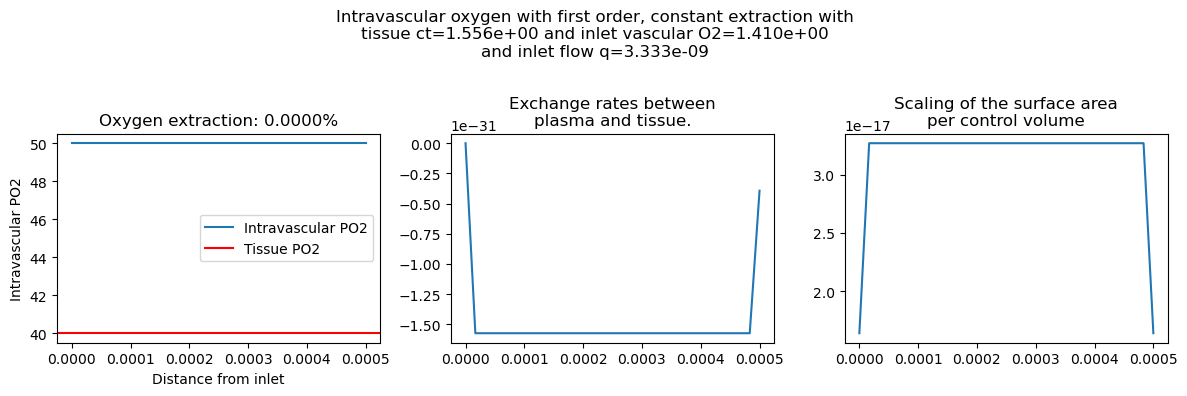

In [92]:
# Flow matrix
def FlowMatrix(CV):
    return sp.dia_matrix((CV.ep['flow'].a, 0), shape=2*[CV.num_edges()]).tocsr()
#Q = sp.dia_matrix((np.random.random(q.a.shape), 0), shape=2*[len(q.a)])

# Q = sp.dia_matrix((q.a, 0), shape=2*[len(q.a)]).tocsr() 

# Advection
def PositivePart(M):
    # Positive part of matrix
    return .5*(M + abs(M))
# M = C1.T @ ( 
#     PositivePart(Q) @ PositivePart(C1) - 
#     PositivePart(-Q) @ PositivePart(-C1)
# )
# Mout = Dout @ C1.T @ Q @ PositivePart(-C1)
# def ConvectionMatrices(CV):
#     C1 = gt.spectral.incidence(CV._vessels).T
#     # Decision matrices
#     Din = sp.dia_matrix(((CV._vessels.get_in_degrees(list(CV._vessels.iter_vertices()))==0).astype(int), 0),
#                         shape=(CV._vessels.num_vertices(), CV._vessels.num_vertices()))
#     # Dout = sp.dia_matrix(((CV._vessels.get_out_degrees(CV._vessels.get_vertices())==0).astype(int), 0),
#     #                     shape=(CV._vessels.num_vertices(), CV._vessels.num_vertices()))    
#     Min  = Din @ C1.T @ Q @ PositivePart(C1)
#     M = (C1.T@(PositivePart(Q)@PositivePart(C1))).T
#     return -M.tocsr(), Min.tocsr(), Din.tocsr()
def ConvectionMatrices(CV):
    C1 = gt.spectral.incidence(CV._vessels).T
    Din = sp.dia_matrix(((CV._vessels.get_in_degrees(list(CV._vessels.iter_vertices()))==0).astype(int), 0),
                        shape=(CV._vessels.num_vertices(), CV._vessels.num_vertices()))
    Dout = sp.dia_matrix(((CV._vessels.get_out_degrees(CV._vessels.get_vertices())==0).astype(int), 0),
                        shape=(CV._vessels.num_vertices(), CV._vessels.num_vertices()))    
    q = CV._vessels.ep['q']
    Q = sp.dia_matrix((q.a, 0), shape=2*[CV._vessels.num_edges()])

    l = CV._vessels.ep['length']
    L = sp.dia_matrix((1.0/l.a, 0), shape=2*[CV._vessels.num_edges()])

    Min  = Din @ C1.T @ Q @ (PositivePart(-C1))
    # MOut = Dout @ C1.T @ Q @ PositivePart(C1)
    M = C1.T@(PositivePart(L@Q)@PositivePart(C1) - PositivePart(-L@Q)@PositivePart(-C1))
    # M -= MOut
    return M.T.tocsr(), Min.T.tocsr(), Din.tocsr()

# Reorder to topological order
## TODO

M, Min, Din = ConvectionMatrices(CV)
# plt.spy(M+Min)
# plt.plot(range(M.shape[0]), range(M.shape[0]), 'r')
# plt.show()

# Boundary conditions
cvBar = Din @ (cIn * np.ones(M.shape[0])) 
tissueSurroundingKeptConstant = np.ones(CV.grid.size)*ctBC

# Surface contact area for each segment with the tissue
s = np.array([np.linalg.norm(CV._vessels.vp['position'][n]) for n in CV._vessels.iter_vertices()])
def SurfaceAreaMatrix(CV):
    # Surface area where O2 can exit the control volume
    N = np.asarray([len(l) for l in CV.VAG.vp['endothelium']])
    C1 = gt.spectral.incidence(CV._vessels).T 
    S = np.where(N!=0, 1/N, 0)
    S = np.multiply(S, abs(C1.T).dot((2*np.pi*CV._vessels.ep['radius'].a)*CV._vessels.ep['length'].a))
    S = sp.spdiags([S], [0])
    return S.tocsr()
S = SurfaceAreaMatrix(CV)

# Solve
CV._vessels.ep['q'].a *= 2
Convection = Min + M
IntravascularOxygen = (sp.eye(*M.shape)-Din)@(C2v.T@S@C2v)
ExtravascularOxygen = (sp.eye(*M.shape)-Din)@C2v.T@S@C2t@tissueSurroundingKeptConstant
# IntravascularOxygen = sp.dia_matrix((2*np.pi*r*CV._vessels.ep['length'].a,0), M.shape)
# ExtravascularOxygen = ctBC * sp.dia_matrix((2*np.pi*r*CV._vessels.ep['length'].a,0), M.shape)@np.ones(M.shape[1])

# cv,_ = sp.linalg.gmres((Convection + Gamma_v/h_v * IntravascularOxygen), Gamma_v/h_v*ExtravascularOxygen + Min@cvBar) 
cv = sp.linalg.spsolve(Convection - Gamma_v/h_v * IntravascularOxygen, -Gamma_v/h_v*ExtravascularOxygen + Din@Min@cvBar)  
# Gamma_v/h_v * sp.eye(cvBar.size)), Gamma_v/h_v*tissueSurroundingKeptConstant + Min@cvBar)
# cv/=alpha
fig = plt.figure(layout='tight', figsize=(12,4))
plt.suptitle(f"Intravascular oxygen with first order, constant extraction with\ntissue ct={tissueSurroundingKeptConstant[0]:.3e} and inlet vascular O2={cIn:.3e}\nand inlet flow q={CV._vessels.ep['q'].a.max():.3e}")
fig.add_subplot(131).plot(s, cv/alpha)
# fig.add_subplot(121).semilogy(s, cv/alpha)
plt.axhline(tissueSurroundingKeptConstant[0]/alpha_t, c='r')
cvtrue = exactSol(s, c0 = cIn/alpha, ct = tissueSurroundingKeptConstant[0]/alpha_t)
# plt.plot(s, cvtrue, c='g')
plt.legend(['Intravascular PO2', 'Tissue PO2', 'Exact solution'])
plt.title(f"Oxygen extraction: {100*(cv[0]-cv[-1])/cv[0]:.4f}%")
plt.xlabel("Distance from inlet")
plt.ylabel("Intravascular PO2")
fig.add_subplot(132).plot(s, S*Gamma_v/h_v*(IntravascularOxygen@(cv) - ExtravascularOxygen))
plt.title("Exchange rates between\nplasma and tissue.")
fig.add_subplot(133).plot(s, S.data)
plt.title("Scaling of the surface area\nper control volume")
plt.show()

### Tissue diffusion

In [15]:
# Cancel diffusion and reaction in vascular voxels
_I = np.ones(CV.grid.size)
vasc = np.fromiter(set(i for i in itertools.chain.from_iterable(CV.VAG.vp['vascular'])), int)
_I[vasc] = 0
del vasc
endo = np.fromiter(set(i for i in itertools.chain.from_iterable(CV.VAG.vp['endothelium'])), int)
_I[endo] = 0
_I = sp.dia_matrix((_I, 0), shape=2*[CV.grid.size])

In [16]:
def get_C3(shape:list[int]|int):
    if isinstance(shape, int):
        shape = 3*[shape]
    lat = lattice(shape, periodic=False)
    lat.set_directed(True)
    C3 = gt.spectral.incidence(lat).T
    return lat, C3.tocsr()

def get_D3(lat:gt.Graph):
    degrees = lat.get_total_degrees(lat.get_vertices())
    D3 = sp.spdiags([(degrees!=degrees.max()).astype(int)], [0])
    return D3.tocsr()

# def get_Diffusion_FirstOrderReaction(C3, voxelSize:float, diffusivity, reactionRate):
#     V = voxelSize**3 # Voxel volume
#     M =  (diffusivity*voxelSize*C3.T@C3) # Diffusivity 
#     M += V * reactionRate * sp.eye(M.shape[0]) # Oxygen consumption
#     return M.tocsr()
def get_Diffusion_FirstOrderReaction(lattice, voxelSize:float, diffusivity, reactionRate):
    V = voxelSize**3 # Voxel volume
    M =  diffusivity * GetDiffusion(lattice, voxelSize) 
    M += V * reactionRate * sp.eye(M.shape[0]) # Oxygen consumption
    return M.tocsr()


def GetDiffusion(lattice, h):
    if lattice.is_directed():
        lattice.set_directed(False)
    D = gt.spectral.laplacian(lattice) / (h**2)
    return D    

### Mass transfer

In [17]:
def SurfaceAreaMatrix(CV):
    # Surface area where O2 can exit the control volume
    N = np.asarray([len(l) for l in CV.VAG.vp['endothelium']])
    C1 = gt.spectral.incidence(CV._vessels).T 
    S = np.pi*np.where(N!=0, 1/N, 0)
    S = np.multiply(S, abs(C1.T).dot(CV._vessels.ep['radius'].a*CV._vessels.ep['length'].a))
    S = sp.spdiags([S], [0])
    return S.tocsr()

In [18]:
# cvBar = cIn * alpha
# ctBar = 40 * alpha_t # concentration of O2 at the boundary of cube

lat, C3 = get_C3(CV.grid.shape)
D3 = get_D3(lat) # Boundary voxels
D3 = sp.eye(D3.shape[0])
D = get_Diffusion_FirstOrderReaction(lat, voxelSize=CV.grid.h[0], diffusivity=Gamma_t, reactionRate=K)
I = sp.eye(D3.shape[0]).tocsr()
F = sp.eye(C2v.shape[1]).tocsr() # O2 dissociation dynamics (could be non-linear)
S = SurfaceAreaMatrix(CV)

### Full system

In [19]:
# A = Din + (sp.eye(Din.shape[0])-Din) @ (Min + M - Gamma_v/h_v * C2v.T@S@C2v@F) # Convection + intravascular PO2 at interface with tissue
A = Convection + IntravascularOxygen
E = (Gamma_v/h_v * C2v.T@S@C2t)    # Extravascular PO2 at interface with vessels
cvBar = Din @ (cIn * np.ones(M.shape[0])) # O2 source

In [20]:
B = (I-D3) @ (D + Gamma_v/h_v*C2t.T@S@C2t) + D3 # Tissue diffusion + reaction
G = Gamma_v/h_v*(I-D3)@C2t.T@S@C2v@F
ctBar = D3 @ (ctBC*np.ones(D3.shape[1]))

In [21]:
_K = csp.csr_matrix(sp.bmat([[A,E], [G,B]]).tocsc())
# del A,E,G,B
y = cp.asarray(np.hstack((cvBar, ctBar)))
sp.save_npz("Overall.npz", _K)


In [22]:
print(type(_K), type(y))

<class 'cupyx.scipy.sparse._csr.csr_matrix'> <class 'cupy.ndarray'>


### Solve

In [23]:
class gmres_counter(object):
    def __init__(self, disp=10):
        self._disp = disp
        self.niter = 0
        self.rks = []

    def __call__(self, rk=None):
        self.niter += 1
        if self.niter%self._disp==0:
            if isinstance(rk, cp.ndarray):
                rk = rk.get()
            self.rks.append(rk)
            print('iter %3i\trk = %s' % (self.niter, str(rk)))

    def __enter__(self):
        self.t1 = time.time()
        return self
    def __exit__(self, type, value, traceback):
        t = (time.time() - self.t1)/60
        plt.plot(self._disp * (1+np.arange(len(self.rks))), self.rks)
        plt.xlabel("Number of iterations")
        plt.ylabel("Residual (relative?)")
        plt.title(f"Solving time: {t}min")
        plt.show()

Exited with code: 0


/home/remi/miniconda3/envs/gt/lib/python3.11/site-packages/cupyx/scipy/sparse/linalg/_iterative.py:192: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ret = numpy.linalg.lstsq(cupy.asnumpy(H), e)


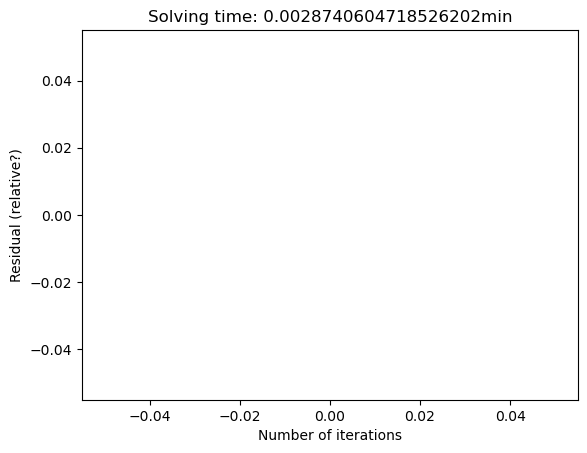

In [24]:
with gmres_counter(disp=200) as callback:
    # x, code = sp.linalg.gmres(_K, y, maxiter=1000, callback=callback)
    x, code = cspl.gmres(_K, y, maxiter=10000, callback=callback)
    print("Exited with code:", code)
# x = cspl.spsolve(_K, y)
# x = sp.linalg.spsolve(K, y)
x = x.get()
cv, ct = x[:A.shape[0]]/alpha, x[A.shape[0]:]/alpha_t

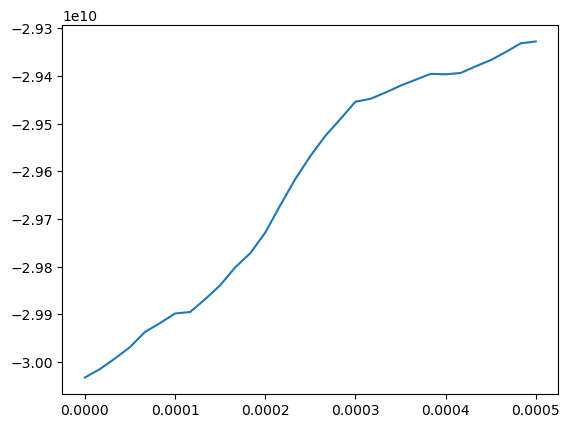

In [25]:
s = [np.linalg.norm(CV._vessels.vp['position'][n]) for n in CV._vessels.iter_vertices()]
plt.plot(s, cv)

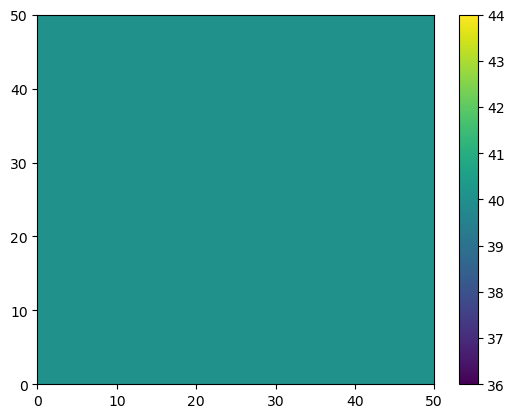

In [26]:
import matplotlib
plt.pcolormesh(ct.reshape(CV.grid.shape)[:, int(ny/2), :])#, norm=matplotlib.colors.LogNorm())
plt.colorbar()
plt.show()

# Schur complement

In [27]:
# from scipy.fftpack import dstn, idstn
from cupyx.scipy.fft import idstn, dstn

def LambdasDirichlet(i, N, h):
    ## Eigenvalues of the 3 points laplcian in 1D
    # with Neumann boundary conditions
    # return (2-2*np.cos(i*np.pi/(N+1)))/(h**2)
    return -4*cp.sin(i*cp.pi/(2*(N)))/(h**2)

def fastPoisson(f, dx,dy,dz, nx,ny,nz):
    dstType = 2
    lambdas = cp.sum(
        cp.asarray(cp.meshgrid(LambdasDirichlet(cp.arange(1,nx+1),nx,dx),
                    LambdasDirichlet(cp.arange(1,ny+1),ny,dy),
                    LambdasDirichlet(cp.arange(1,nz+1),nz,dz),
                    indexing='ij')),
        axis=0)
    u_hat = dstn(f, type=dstType, norm='ortho')/cp.where(lambdas==0, cp.inf, lambdas)
    u = cp.real(idstn(u_hat, type=dstType, norm='ortho'))
    return cp.asarray(u)
rtol = 1e-4

In [28]:
B = csp.csr_matrix(B)
G = csp.csr_matrix(G)
A = csp.csr_matrix(A)
E = csp.csr_matrix(E)

triSolve = cspl.spsolve_triangular

def Sc_func(x):
    '''Schur complement system'''
    return B@x + (G@triSolve(A, E@x)) 
def Make_bc(bv, bt):
    '''Make the bc for the Schur complement system'''
    return cp.asarray(bt) - G@(triSolve(A, cp.asarray(bv)))
def cv_func(ct, cvBar):
    return triSolve(A, cvBar - E@ct)

# Sc = sp.linalg.LinearOperator((CV.grid.size, CV.grid.size), Sc_func)
Sc = cspl.LinearOperator((CV.grid.size, CV.grid.size), Sc_func)
bc = cp.asarray(Make_bc(cvBar, ctBar))

# Preconditionner
# P = sp.linalg.LinearOperator(shape=Sc.shape, 
#                        matvec=lambda x: fastPoisson(x.reshape(CV.grid.n), *CV.grid.h, *CV.grid.n).ravel())
P = cspl.LinearOperator(shape=Sc.shape, 
                        matvec=lambda x: fastPoisson(x.reshape(CV.grid.n), *CV.grid.h, *CV.grid.n).ravel())

Exited with code 0


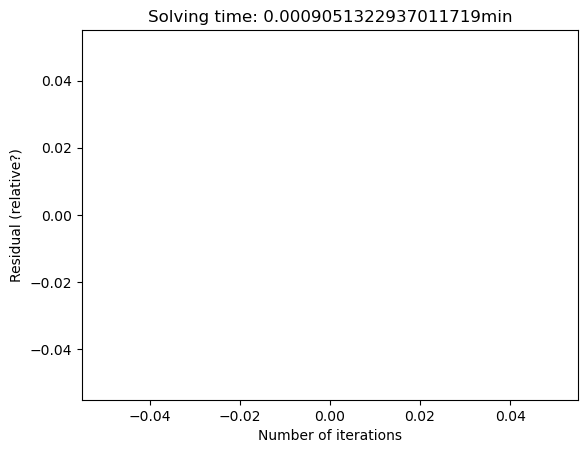

In [29]:
with gmres_counter(disp=100) as callback:
    # ct, code = sp.linalg.gmres(Sc, bc, M=P, restart=10, callback=callback, maxiter=2000)
    ct, code = cspl.gmres(Sc, bc, M=P, restart=10, callback=callback, maxiter=2000, atol=1e-3)
    print("Exited with code", code)
cv = cv_func(ct, cp.asarray(cvBar))
ct /= alpha_t
cv /= alpha
ct = ct.get()
cv = cv.get()

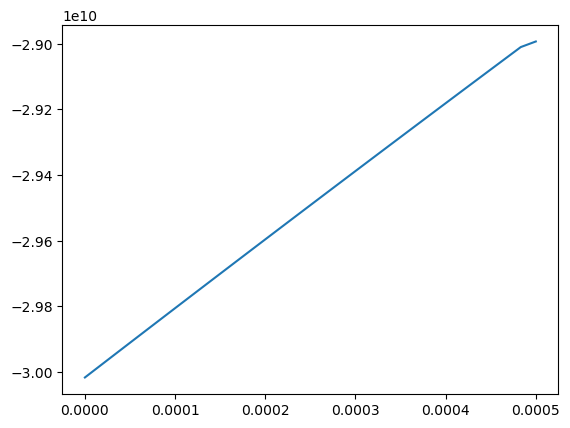

In [30]:
s = [np.linalg.norm(CV._vessels.vp['position'][n]) for n in CV._vessels.iter_vertices()]
plt.plot(s, cv)

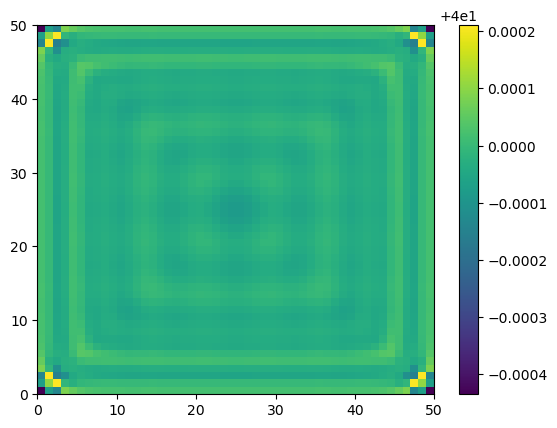

In [31]:
plt.pcolormesh(ct.reshape(CV.grid.shape)[:, int(ny/2), :])
plt.colorbar()
plt.show()